<a href="https://colab.research.google.com/github/neer201/space_junk_simulator/blob/master/1%20-%20Debug%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Стадия I

Программа принимает на вход скорости и координаты космических объектов и рассчитывает их положение и
скорость в зависимости от времени методом численного решения уравнений Ньютона. Обоснован выбор
разностной схемы и шага интеграции, требуемая точность - 10 cм за неделю. Расчёт на GPU
Все расчёты в системе единиц СИ. Чтобы так не получилось.



В коде есть интерфейс для простого добавления новых сил, действующих на объекты. Силы могут зависеть от
времени, скорости и координат объекта, параметров объекта. В нём реализована элементарная модель
гравитации, где Земля - шар.

Есть визуализатор, для заданных id объектов и интервалу времени, рисующий их траекторию картинкой. В отчёте
есть траектории 10 случайных объектов на протяжении суток.

In [0]:
import csv
import numpy as np
import numpy as np

# Генератор входных данных

Есть код, генерирующий случайные начальные условия для 21000 объектов. Круговые орбиты, высота
распределена по Гауссу, средняя 800 км, дисперсия 200 км, плоскости - равномерно. Размеры объектов от 1 см до
10 м, распределены с pdf = 1/object_size

Формат данных для каждого обьекта

- ```object_id```
- ```position```
- ```size```
- ```motion_vector```

Допустим мы напишем генератор на python и данные по обьектам будем просто писать в csv файл.

https://upload.wikimedia.org/wikipedia/commons/2/24/Orbital_state_vectors.png

https://upload.wikimedia.org/wikipedia/commons/c/c0/Spherical_with_grid.svg

In [0]:
def spherical_to_decart(radius, theta, phi):
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z


def decart_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y / x)
    return r, theta, phi


In [0]:
def draw_random_number_from_pdf(pdf, interval, pdfmax=1, integers=False, max_iterations=10000):
    """
    Draws a random number from given probability density function.

    Parameters
    ----------
        pdf       -- the function pointer to a probability density function of form P = pdf(x)
        interval  -- the resulting random number is restricted to this interval
        pdfmax    -- the maximum of the probability density function
        integers  -- boolean, indicating if the result is desired as integer
        max_iterations -- maximum number of 'tries' to find a combination of random numbers (rand_x, rand_y) located below the function value calc_y = pdf(rand_x).

    returns a single random number according the pdf distribution.
    """
    for i in range(max_iterations):
        if integers == True:
            rand_x = np.random.randint(interval[0], interval[1])
        else:
            # (b - a) * random_sample() + a
            rand_x = (interval[1] - interval[0]) * \
                np.random.random(1) + interval[0]

        rand_y = pdfmax * np.random.random(1)
        calc_y = pdf(rand_x)

        if (rand_y <= calc_y):
            return rand_x

    raise Exception("Could not find a matching random number within pdf in " +
                    max_iterations + " iterations.")



In [0]:
def generate_object_states(object_count=100,
                           orbit_type='circle',
                           orbit_altitude_mean=800000,
                           orbit_altitude_var=200000,
                           object_min_size=0.1,
                           object_max_size=10.0) -> 'list of object parameters':
   
  

    """Generate object position"""
    mu, sigma, size = orbit_altitude_mean, orbit_altitude_var, object_count
    altitudes = np.random.normal(mu, sigma, size)

    thetas_0 = np.random.uniform(0, 2*np.pi, size=object_count)
    phis_0 = np.random.uniform(0, 2*np.pi, size=object_count)
    
    
    """Generate speed vector"""

    """Generate object sizes"""
    sizes = [draw_random_number_from_pdf(lambda x: 1 / x, [object_min_size, object_max_size])[0]
             for _ in range(object_count)]

    object_list = []
    for object_idx, altitude, theta_0, phi_0, size in zip(
            range(object_count), altitudes, thetas_0, phis_0, sizes):
        x_0, y_0, z_0 = spherical_to_decart(altitude, theta_0, phi_0)
        
        
        eps = 0.000000001*np.pi
        theta_1 = np.random.uniform(theta_0 - eps, theta_0 + eps, size=1)
        phi_1 = np.random.uniform(phi_0 - eps, phi_0 + eps, size=1)
        x_1, y_1, z_1 = spherical_to_decart(altitude, theta_1, phi_1)
       
        
        vx_0 = x_1 - x_0
        vy_0 = y_1 - y_0
        vz_0 = z_1 - z_0
        
      
        
        object_list.append({'time': 0.0,
                            'object_id': object_idx,
                            'x': x_0,
                            'y': y_0,
                            'z': z_0,
                            'vx' : vx_0[0],
                            'vy' : vy_0[0],
                            'vz' : vz_0[0],
                            'size': size})

    return object_list

In [0]:
def generates_objects_in_file(filename,
                              object_count=100,
                              orbit_type='circle',
                              orbit_altitude_mean=800000,
                              orbit_altitude_var=200000,
                              object_min_size=0.1,
                              object_max_size=10.0):
    object_list = generate_object_states(object_count, orbit_type, orbit_altitude_mean,
                                            orbit_altitude_var, object_min_size, object_max_size)
    time = 0
    with open(filename, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=' ',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for space_object in object_list:
            spamwriter.writerow([time,
                                 space_object['object_id'],
                                 space_object['x'],
                                 space_object['y'],
                                 space_object['z'],
                                 space_object['vx'],
                                 space_object['vy'],
                                 space_object['vz'],
                                 space_object['size']])
    return -1

In [95]:
generates_objects_in_file('objects.csv', object_count=1)

-1

In [96]:
!head objects.csv

0 0 -293137.5073949523 289384.7320252186 -822435.2375066729 -0.0017002025851979852 0.0006797147216275334 0.0008451633621007204 2.377887561148939


In [0]:
def randint_with_dist(pdf):
    choices = []
    for index, value in enumerate(pdf):
        choices.extend(index for _ in range(value))
    return random.choice(choices)

# Forces


In [98]:
G = 6.67408e-11
M = 5.972e24

print(' G =', G, '\n', 'M =', M)

 G = 6.67408e-11 
 M = 5.972e+24


In [99]:
G*M

398576057600000.06

In [0]:
objects = generate_object_states(1)

In [101]:
print(objects)

[{'time': 0.0, 'object_id': 0, 'x': -724983.0971898556, 'y': -435851.0969774283, 'z': 73663.67307819967, 'vx': 0.0007655603112652898, 'vy': -0.0012959454907104373, 'vz': -0.00013332258095033467, 'size': 1.333611942806206}]


In [0]:
def get_forces_of_batch():
    accels_batch = []
    for space_object in batch:
        ax_1, ay_1, az_1 = get_accels(space_object)
        accels_batch.append([ax_1, ay_1, az_1])
        
    return accels_batch

In [0]:
def get_accels(x0, y0, z0, vx0, vy0, vz0, ax0=0, ay0=0, az0=0, time=0, forces = 'simple_gravity'):
    forces_set = ['simple_gravity']
    ax, ay, az = 0,0,0
    if forces  in forces_set:
        radius = np.sqrt(x0**2 + y0**2 + z0**2)
        gravity_part = (G * M) / radius
        ax, ay, az = [- gravity_part * vector for vector in [x0, y0, z0]]
        
    return  ax, ay, az

# ODE Solver (RK4 in 3d)

In [104]:
0.001/2.0

0.0005

In [0]:
def rk4_step(time, x0, y0, z0, vx0, vy0, vz0, timestep):

    dt = timestep * 2.0
    dt2 = timestep   # half of timestep

    ax0, ay0, az0 = get_accels(x0, y0, z0, vx0, vy0, vz0)

    # RK4 Calc k1, l1 vars
    kx1 = ax0 * dt2
    ky1 = ay0 * dt2
    kz1 = az0 * dt2

    lx1 = vx0 * dt2
    ly1 = vy0 * dt2
    lz1 = vz0 * dt2

    ax1, ay1, az1 = get_accels(x0 + lx1, y0 + ly1, z0 + lz1, vx0 + kx1,
                               vy0 + ky1, vz0 + kz1)

    # RK4 Calc k2, l2  vars
    kx2 = ax1 * dt2
    ky2 = ay1 * dt2
    kz2 = az1 * dt2

    lx2 = (vx0 + kx1) * dt2
    ly2 = (vy0 + ky1) * dt2
    lz2 = (vz0 + kz1) * dt2

    ax2, ay2, az2 = get_accels(x0 + lx2, y0 + ly2, z0 + lz2, vx0 + kx2,
                               vy0 + ky2, vz0 + kz2)

    # RK4 Calc k3, l3  vars
    kx3 = ax2 * dt
    ky3 = ay2 * dt
    kz3 = az2 * dt

    lx3 = (vx0 + kx2) * dt
    ly3 = (vy0 + ky2) * dt
    lz3 = (vz0 + kz2) * dt

    ax3, ay3, az3 = get_accels(x0 + lx3, y0 + ly3, z0 + lz3, vx0 + kx3,
                               vy0 + ky3, vz0 + kz3)

    # RK4 Calc k3, l3  vars
    kx4 = ax3 * dt2
    ky4 = ay3 * dt2
    kz4 = az3 * dt2

    lx4 = (vx0 + kx3) * dt2
    ly4 = (vy0 + ky3) * dt2
    lz4 = (vz0 + kz3) * dt2

    x_step = x0 + (lx1 + 2.0 * lx2 + lx3 + lx4) / 3.0
    y_step = y0 + (ly1 + 2.0 * ly2 + ly3 + ly4) / 3.0
    z_step = z0 + (lz1 + 2.0 * lz2 + lz3 + lz4) / 3.0

    vx_step = vx0 + (kx1 + 2.0 * kx2 + kx3 + kx4) / 3.0
    vy_step = vy0 + (ky1 + 2.0 * ky2 + ky3 + ky4) / 3.0
    vz_step = vz0 + (kz1 + 2.0 * kz2 + kz3 + kz4) / 3.0

    return x_step, y_step, z_step, vx_step, vy_step, vz_step

# Визуализация

In [0]:
space_objects = generate_object_states(2)

In [107]:
for space_object in space_objects:
    print(space_object)

{'time': 0.0, 'object_id': 0, 'x': 25217.424362950926, 'y': -496457.41386781185, 'z': 650671.2495281389, 'vx': 0.0014348032818816137, 'vy': -0.00088002800475806, 'vz': -0.0007270622299984097, 'size': 5.933089989621293}
{'time': 0.0, 'object_id': 1, 'x': 32607.467348780316, 'y': 111403.94605749802, 'z': 807973.5680421025, 'vx': 0.00011244734560023062, 'vy': 0.0003848432534141466, 'vz': -5.760055501013994e-05, 'size': 0.8289531015153386}


In [0]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

  0%|          | 29/10000 [00:00<00:35, 283.41it/s]

{'time': 0.0, 'object_id': 0, 'x': 25217.424362950926, 'y': -496457.41386781185, 'z': 650671.2495281389, 'vx': 0.0014348032818816137, 'vy': -0.00088002800475806, 'vz': -0.0007270622299984097, 'size': 5.933089989621293}


100%|██████████| 10000/10000 [00:22<00:00, 438.07it/s]


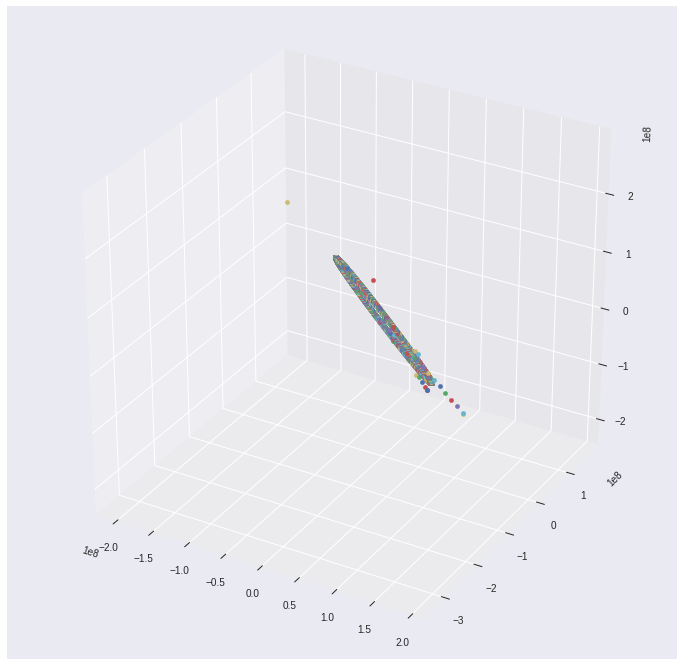

In [109]:
from tqdm import trange
simulation_steps = 10000
time_step = 0.001  # s
simulation_history = []

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

for space_object in space_objects[:1]:
    print(space_object)
    time0 = space_object['time']
    x0, y0, z0, vx0, vy0, vz0 = [space_object[var] \
                                 for var in ('x', 'y', 'z', 'vx', 'vy', 'vz')]
    # vx0, vy0, vz0 = 0,0,0
    objects_steps = []
    for simulation_step in trange(simulation_steps):
        
    
        x1, y1, z1, vx1, vy1, vz1 = rk4_step(time0+simulation_step*time_step, 
                                             x0, y0, z0, vx0, vy0, vz0,
                                             timestep=time_step)
       
       
        object_step = dict()
        
        object_step['x'] = x1
        object_step['y'] = y1
        object_step['z'] = z1
        object_step['vx'] = vx1
        object_step['vy'] = vy1
        object_step['vz'] = vz1
        objects_steps.append(object_step)
        
        x0, y0, z0, vx0, vy0, vz0 =  x1, y1, z1, vx1, vy1, vz1
        ax.scatter3D( x1, y1, z1)

    simulation_history.append(objects_steps)

In [0]:
for object_step in objects_steps[:5]:
    print(object_step['x'], object_step['y'], object_step['z'])
       

-12782116.589295072 250687789.2148399 85601461.68920903
24542.94860940799 -481345.7472835779 -164363.40872445703
-12782116.965323579 250687789.1704056 85601461.76318787
24543.06830949895 -481345.7331379056 -164363.43227651715
-12782287.86683421 250687768.97408888 85601495.38961734


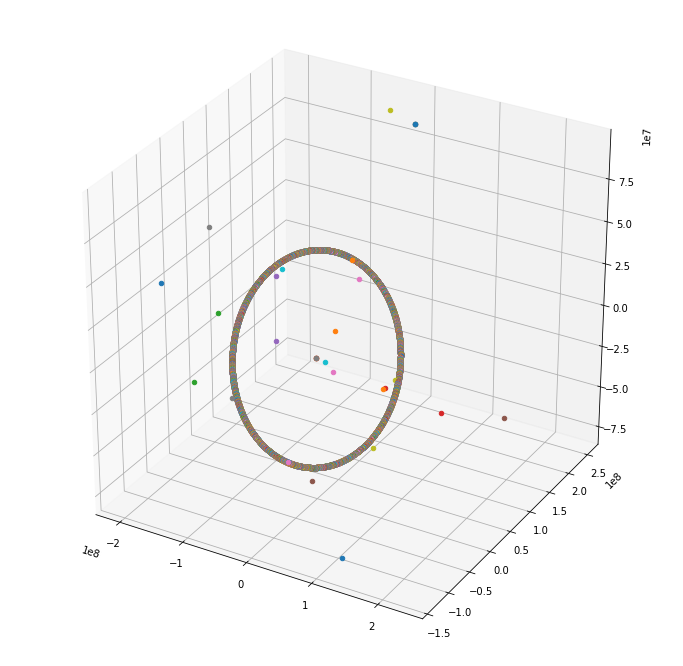

In [0]:


# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 


plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

for object_step in objects_steps:
    ax.scatter3D(object_step['x'], object_step['y'], object_step['z'])
plt.show()

In [0]:
import csv
object_list = []

with open('objects.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    line_count = 0
    for row in csv_reader:
        print(row[0])
    print(f'Processed {line_count} lines.')

ValueError: could not convert string to float: '0 0 -187635.1169015475 574722.8334821202 559501.0452130205 0.0014652525132987648 0.00028180587105453014 0.00020191667135804892 2.2412468921504876'

In [0]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook

fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = list(range(0, 100))
sequence_containing_y_vals = list(range(0, 100))
sequence_containing_z_vals = list(range(0, 100))

random.shuffle(sequence_containing_x_vals)
random.shuffle(sequence_containing_y_vals)
random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

<IPython.core.display.Javascript object>


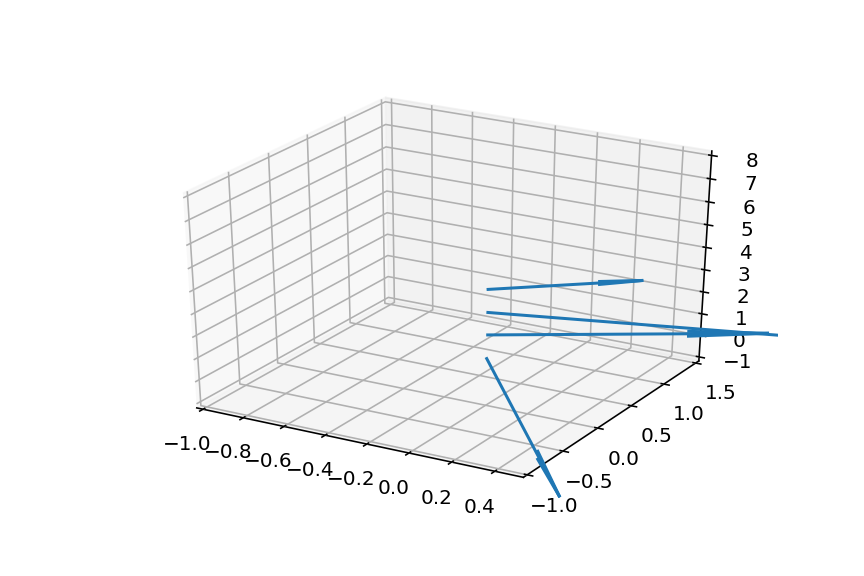

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook

soa = np.array([[0, 0, 1, 1, -2, 0], [0, 0, 2, 1, 1, 0],
                [0, 0, 3, 2, 1, 0], [0, 0, 4, 0.5, 0.7, 0]])

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-1, 0.5])
ax.set_ylim([-1, 1.5])
ax.set_zlim([-1, 8])
plt.show()



# CPP impementation

In [0]:
%%writefile lib/rk.cpp
#include <iostream>


extern "C" 
class Foo{
    public:
        void bar(int input_var, int &output_var){
            std::cout << "Hello" << std::endl;
            output_var = input_var*2;
        }
};
}

Overwriting lib/rk.cpp


In [0]:
!cd lib && g++ -c -fPIC rk.cpp -o rk.o
!cd lib && g++ -shared -Wl, -o rk.so  rk.o


In [0]:
from ctypes import cdll
lib = cdll.LoadLibrary('lib/rk.so')

class Foo(object):
    def __init__(self):
        self.obj = lib.Foo_new()

    def bar(self):
        lib.Foo_bar(self.obj)


In [0]:
f = Foo()

In [0]:
x = 2
y = 2

In [0]:
f.bar(x,y)

TypeError: bar() takes 1 positional argument but 3 were given

In [0]:
%%writefile lib/rk.cpp
/** 
 * Compute the sum an array
 * @param n number of elements
 * @param array input array
 * @return sum
 */
extern "C" // required when using C++ compiler
long long mysum(int n, int* array) {
    // return type is 64 bit integer
    long long res = 0;
    for (int i = 0; i < n; ++i) {
        res += array[i];
    }
    return res;
}

Overwriting lib/rk.cpp


In [0]:
!cd lib && g++ -c -fPIC rk.cpp -o rk.o
!cd lib && g++ -shared -Wl, -o rk.so  rk.o


In [0]:
import ctypes
import numpy
import glob

# find the shared library, the path depends on the platform and Python version
libfile = glob.glob('lib/rk.so')[0]

# 1. open the shared library
mylib = ctypes.CDLL(libfile)

# 2. tell Python the argument and result types of function mysum
mylib.mysum.restype = ctypes.c_longlong
mylib.mysum.argtypes = [ctypes.c_int, 
                        numpy.ctypeslib.ndpointer(dtype=numpy.int32)]

array = numpy.arange(0, 100000000, 1, numpy.int32)

# 3. call function mysum
array_sum = mylib.mysum(len(array), array)

print('sum of array: {}'.format(array_sum))


AttributeError: dlsym(0x7fca85f87320, mysum): symbol not found

In [0]:
f = Foo()

In [0]:
x = 2
y = 2

# CUDA implementaition


Tutorials:
* https://devblogs.nvidia.com/even-easier-introduction-cuda/
* run CUDA in colab - https://medium.com/@iphoenix179/running-cuda-c-c-in-jupyter-or-how-to-run-nvcc-in-google-colab-663d33f53772

In [2]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-v5f1hsox
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojdd8a9i/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [4]:
%load_ext nvcc_plugin

directory /content/src already exists
Out bin /content/result.out


In [5]:
%%cu
#include <iostream>
int main() {
    std::cout << "Hello world\n";
    return 0;
}

'Hello world\n'

In [6]:
%%cu 
#include <iostream>
#include <math.h>
// Kernel function to add the elements of two arrays
__global__
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
    y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20;
  float *x, *y;

  // Allocate Unified Memory – accessible from CPU or GPU
  cudaMallocManaged(&x, N*sizeof(float));
  cudaMallocManaged(&y, N*sizeof(float));

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the GPU
  add<<<1, 1>>>(N, x, y);

  // Wait for GPU to finish before accessing on host
  cudaDeviceSynchronize();

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  cudaFree(x);
  cudaFree(y);
  std::cout << "Hello world\n";
  return 0;
}

'Max error: 0\nHello world\n'

In [7]:
%%writefile add.cpp
#include <iostream>
#include <math.h>

// function to add the elements of two arrays
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
      y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20; // 1M elements

  float *x = new float[N];
  float *y = new float[N];

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the CPU
  add(N, x, y);

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  delete [] x;
  delete [] y;

  return 0;
}

Overwriting add.cpp


In [0]:
!clang++ add.cpp -o add

In [9]:
!./add

Max error: 0


In [10]:
%%writefile add.cu

#include <iostream>
#include <math.h>
// Kernel function to add the elements of two arrays
__global__
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
    y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20;
  float *x, *y;

  // Allocate Unified Memory – accessible from CPU or GPU
  cudaMallocManaged(&x, N*sizeof(float));
  cudaMallocManaged(&y, N*sizeof(float));

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the GPU
  add<<<1, 1>>>(N, x, y);

  // Wait for GPU to finish before accessing on host
  cudaDeviceSynchronize();

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  cudaFree(x);
  cudaFree(y);
  
  return 0;
}

Overwriting add.cu


In [0]:
!nvcc add.cu -o add_cuda

In [12]:
!./add_cuda

Max error: 0


In [13]:
!nvprof ./add_cuda

==497== NVPROF is profiling process 497, command: ./add_cuda
Max error: 0
==497== Profiling application: ./add_cuda
==497== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  447.81ms         1  447.81ms  447.81ms  447.81ms  add(int, float*, float*)
      API calls:   67.15%  447.88ms         1  447.88ms  447.88ms  447.88ms  cudaDeviceSynchronize
                   32.17%  214.58ms         2  107.29ms  792.61us  213.78ms  cudaMallocManaged
                    0.41%  2.7049ms         1  2.7049ms  2.7049ms  2.7049ms  cudaLaunchKernel
                    0.18%  1.2041ms         2  602.06us  544.96us  659.16us  cudaFree
                    0.06%  391.74us        96  4.0800us     155ns  165.56us  cuDeviceGetAttribute
                    0.03%  176.23us         1  176.23us  176.23us  176.23us  cuDeviceTotalMem
                    0.00%  22.984us         1  22.984us  22.984us  22.984us  cuDeviceGetName
               

In [14]:
%%writefile add.cu

#include <iostream>
#include <math.h>
// Kernel function to add the elements of two arrays
__global__
void add(int n, float *x, float *y)
{
  int index = blockIdx.x * blockDim.x + threadIdx.x;
  int stride = blockDim.x * gridDim.x;
  for (int i = index; i < n; i += stride)
    y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20;
  float *x, *y;

  // Allocate Unified Memory – accessible from CPU or GPU
  cudaMallocManaged(&x, N*sizeof(float));
  cudaMallocManaged(&y, N*sizeof(float));

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the GPU
  int blockSize = 256;
  int numBlocks = (N + blockSize - 1) / blockSize;
  add<<<numBlocks, blockSize>>>(N, x, y);

  // Wait for GPU to finish before accessing on host
  cudaDeviceSynchronize();

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  cudaFree(x);
  cudaFree(y);
  
  return 0;
}

Overwriting add.cu


In [0]:
!nvcc add.cu -o add_cuda

In [16]:
!./add_cuda

Max error: 0


In [17]:
!nvprof ./add_cuda

==575== NVPROF is profiling process 575, command: ./add_cuda
Max error: 0
==575== Profiling application: ./add_cuda
==575== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  102.85us         1  102.85us  102.85us  102.85us  add(int, float*, float*)
      API calls:   97.93%  174.74ms         2  87.372ms  928.96us  173.82ms  cudaMallocManaged
                    1.00%  1.7840ms         1  1.7840ms  1.7840ms  1.7840ms  cudaLaunchKernel
                    0.60%  1.0628ms         2  531.38us  441.48us  621.28us  cudaFree
                    0.25%  450.01us        96  4.6870us     161ns  190.58us  cuDeviceGetAttribute
                    0.14%  244.01us         1  244.01us  244.01us  244.01us  cuDeviceTotalMem
                    0.06%  114.26us         1  114.26us  114.26us  114.26us  cudaDeviceSynchronize
                    0.01%  24.269us         1  24.269us  24.269us  24.269us  cuDeviceGetName
               

# PyCUDA

In [1]:
!pip install pycuda

In [0]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np

In [0]:
from pycuda.compiler import SourceModule
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")


In [24]:
multiply_them = mod.get_function("multiply_them")

a = np.random.randn(400).astype(np.float32)
b = np.random.randn(400).astype(np.float32)

dest = np.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [0]:
__global__
void rk4_step(float *time, 
              float *x0, float *y0, float *z0, 
              float *vx0, float *vy0, float *vz0, float* timestep,
              float *x_step, float *y_step, float *z_step, 
              float *vx_step, float *vy_step, float *vz_step) {

    const float dt = timestep * 2.0;
    const float dt2 = timestep;   // half of timestep
    
    
    float ax0, ay0, az0;
    get_accels(x0, y0, z0, vx0, vy0, vz0);

    // RK4 Calc k1, l1 vars
    float kx1 = ax0 * dt2;
    float ky1 = ay0 * dt2;
    float kz1 = az0 * dt2;

    float lx1 = vx0 * dt2;
    float ly1 = vy0 * dt2;
    float lz1 = vz0 * dt2;

    float ax1, ay1, az1;
    get_accels(x0 + lx1, y0 + ly1, z0 + lz1, vx0 + kx1,
                               vy0 + ky1, vz0 + kz1);

    // RK4 Calc k2, l2  vars
    float kx2 = ax1 * dt2;
    float ky2 = ay1 * dt2;
    float kz2 = az1 * dt2;

    float lx2 = (vx0 + kx1) * dt2;
    float ly2 = (vy0 + ky1) * dt2;
    float lz2 = (vz0 + kz1) * dt2;

    float ax2, ay2, az2;
    get_accels(x0 + lx2, y0 + ly2, z0 + lz2, vx0 + kx2,
                               vy0 + ky2, vz0 + kz2);

    // RK4 Calc k3, l3  vars
    float kx3 = ax2 * dt;
    float ky3 = ay2 * dt;
    float kz3 = az2 * dt;

    float lx3 = (vx0 + kx2) * dt;
    float ly3 = (vy0 + ky2) * dt;
    float lz3 = (vz0 + kz2) * dt;

    float ax3, ay3, az3;
    get_accels(x0 + lx3, y0 + ly3, z0 + lz3, vx0 + kx3,
                               vy0 + ky3, vz0 + kz3);

    // RK4 Calc k3, l3  vars
    float kx4 = ax3 * dt2;
    float ky4 = ay3 * dt2;
    float kz4 = az3 * dt2;

    float lx4 = (vx0 + kx3) * dt2;
    float ly4 = (vy0 + ky3) * dt2;
    float lz4 = (vz0 + kz3) * dt2;

    x_step = x0 + (lx1 + 2.0 * lx2 + lx3 + lx4) / 3.0;
    y_step = y0 + (ly1 + 2.0 * ly2 + ly3 + ly4) / 3.0;
    z_step = z0 + (lz1 + 2.0 * lz2 + lz3 + lz4) / 3.0;

    vx_step = vx0 + (kx1 + 2.0 * kx2 + kx3 + kx4) / 3.0;
    vy_step = vy0 + (ky1 + 2.0 * ky2 + ky3 + ky4) / 3.0;
    vz_step = vz0 + (kz1 + 2.0 * kz2 + kz3 + kz4) / 3.0;
}
   

In [117]:
%%writefile rk4.cu 

#include <math.h>
__device__
void get_accels(float x0, float y0, float z0, 
                float vx0, float vy0, float vz0,
                float &ax1, float &ay1, float &az1) {
    float G = 6.67408E-11;
    float M = 5.972E24;
    float radius =  sqrt(pow(x0,2) + pow(y0,2) + pow(z0,2));
    
    ax1 = - ((G * M) / radius) * x0;
    ay1 = - ((G * M) / radius) * y0;
    az1 = - ((G * M) / radius) * z0;
}

__global__
void rk4_step(float time, 
              float x0, float y0, float z0, 
              float vx0, float vy0, float vz0, float timestep,
              float &x_step, float &y_step, float &z_step, 
              float &vx_step, float &vy_step, float &vz_step) {

    const float dt = timestep * 2.0;
    const float dt2 = timestep;   // half of timestep
    
    
    float ax0, ay0, az0;
    get_accels(x0, y0, z0, vx0, vy0, vz0, ax0, ay0, az0);

    // RK4 Calc k1, l1 vars
    float kx1 = ax0 * dt2;
    float ky1 = ay0 * dt2;
    float kz1 = az0 * dt2;

    float lx1 = vx0 * dt2;
    float ly1 = vy0 * dt2;
    float lz1 = vz0 * dt2;

    float ax1, ay1, az1;
    get_accels(x0 + lx1, y0 + ly1, z0 + lz1, 
               vx0 + kx1, vy0 + ky1, vz0 + kz1, 
               ax1, ay1, az1);

    // RK4 Calc k2, l2  vars
    float kx2 = ax1 * dt2;
    float ky2 = ay1 * dt2;
    float kz2 = az1 * dt2;

    float lx2 = (vx0 + kx1) * dt2;
    float ly2 = (vy0 + ky1) * dt2;
    float lz2 = (vz0 + kz1) * dt2;

    float ax2, ay2, az2;
    get_accels(x0 + lx2, y0 + ly2, z0 + lz2, 
               vx0 + kx2, vy0 + ky2, vz0 + kz2, 
               ax2, ay2, az2);

    // RK4 Calc k3, l3  vars
    float kx3 = ax2 * dt;
    float ky3 = ay2 * dt;
    float kz3 = az2 * dt;

    float lx3 = (vx0 + kx2) * dt;
    float ly3 = (vy0 + ky2) * dt;
    float lz3 = (vz0 + kz2) * dt;

    float ax3, ay3, az3;
    get_accels(x0 + lx3, y0 + ly3, z0 + lz3, 
               vx0 + kx3, vy0 + ky3, vz0 + kz3,
               ax3, ay3, az3);

    // RK4 Calc k3, l3  vars
    float kx4 = ax3 * dt2;
    float ky4 = ay3 * dt2;
    float kz4 = az3 * dt2;

    float lx4 = (vx0 + kx3) * dt2;
    float ly4 = (vy0 + ky3) * dt2;
    float lz4 = (vz0 + kz3) * dt2;

    x_step = x0 + (lx1 + 2.0 * lx2 + lx3 + lx4) / 3.0;
    y_step = y0 + (ly1 + 2.0 * ly2 + ly3 + ly4) / 3.0;
    z_step = z0 + (lz1 + 2.0 * lz2 + lz3 + lz4) / 3.0;

    vx_step = vx0 + (kx1 + 2.0 * kx2 + kx3 + kx4) / 3.0;
    vy_step = vy0 + (ky1 + 2.0 * ky2 + ky3 + ky4) / 3.0;
    vz_step = vz0 + (kz1 + 2.0 * kz2 + kz3 + kz4) / 3.0;
}
   

Overwriting rk4.cu


In [225]:
%%writefile rk4.cu 

#include <math.h>
__device__
void get_accels(float x0, float y0, float z0, 
                float vx0, float vy0, float vz0,
                float &ax1, float &ay1, float &az1) {
    float G = 6.67408E-11;
    float M = 5.972E24;
    float radius =  sqrt(pow(x0,2) + pow(y0,2) + pow(z0,2));
    
    ax1 = - ((G * M) / radius) * x0;
    ay1 = - ((G * M) / radius) * y0;
    az1 = - ((G * M) / radius) * z0;
}

__global__
void rk4_step_cuda(float *x0, float *x_step) {
    const int idx = threadIdx.x0;
    
    x_step[idx] = x0[idx];
}
   

Overwriting rk4.cu


In [226]:
!nvcc rk4.cu -o rk4

rk4.cu(18): error: class "uint3" has no member "x0"

1 error detected in the compilation of "/tmp/tmpxft_0000064a_00000000-8_rk4.cpp1.ii".


In [0]:
code = open('rk4.cu', 'r').read()

In [228]:
code

'\n#include <math.h>\n__device__\nvoid get_accels(float x0, float y0, float z0, \n                float vx0, float vy0, float vz0,\n                float &ax1, float &ay1, float &az1) {\n    float G = 6.67408E-11;\n    float M = 5.972E24;\n    float radius =  sqrt(pow(x0,2) + pow(y0,2) + pow(z0,2));\n    \n    ax1 = - ((G * M) / radius) * x0;\n    ay1 = - ((G * M) / radius) * y0;\n    az1 = - ((G * M) / radius) * z0;\n}\n\n__global__\nvoid rk4_step_cuda(float *x0, float *x_step) {\n    const int idx = threadIdx.x0;\n    \n    x_step[idx] = x0[idx];\n}\n   '

In [229]:
from pycuda.compiler import SourceModule

mod = SourceModule(code)

CompileError: ignored

In [0]:
rk4_step_cuda = mod.get_function("rk4_step_cuda")

In [0]:
space_objects

In [0]:
import pandas as pd
a = pd.DataFrame(space_objects).values

object_id = a[:, 0]
x0 = a[:, 6]
y0 = a[:, 7]
z0 = a[:, 8]

vx0 = a[:, 3]
vy0 = a[:, 4]
vz0 = a[:, 5] 

x1 = np.zeros_like(x0)
y1 = np.zeros_like(y0)
z1 = np.zeros_like(z0)

vx1 = np.zeros_like(vx1)
vy1 = np.zeros_like(vy1)
vz1 = np.zeros_like(vz1)

In [0]:
x0

In [0]:
x1

In [277]:
mod = SourceModule("""
__global__ void rk4_step_cuda(float *a, float *dest)
{
  const int i = threadIdx.x;
  dest[i] = a[i];
}
""")


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



CompileError: ignored

In [0]:
rk4_step_cuda = mod.get_function("rk4_step_cuda")

```loat time, 
              float x0, float y0, float z0, 
              float vx0, float vy0, float vz0, float timestep,
              float &x_step, float &y_step, float &z_step, 
              float &vx_step, float &vy_step, float &vz_step```

In [270]:
 np.random.randn(400).astype(np.float32).shape

(400,)

In [0]:
import pycuda.driver as drv
rk4_step_cuda(drv.In(x0),  drv.Out(x1),
              block=(2,1,1))


In [275]:
x0

array([25217.42436295, 32607.46734878])

In [273]:
x1

array([3.37882969e-315, 0.00000000e+000])

In [0]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from pycuda.compiler import SourceModule


mod = SourceModule("""
__global__ void sum_ab(float *c, float *a, float *b)
{
  const int i = threadIdx.x + blockDim.x * blockIdx.x;
  c[i] = a[i] + b[i];
}
""")


sum_ab = mod.get_function("sum_ab")

N = 5

a = np.array(range(N)).astype(np.float32)
b = np.array(range(N)).astype(np.float32)
c = np.zeros_like(a)


In [0]:
block_size = N if N < 32  else 32
block_dim = (block_size, 1, 1)
grid_dim = (N//block_size,1)

In [0]:
sum_ab(drv.Out(c), drv.In(a), drv.In(b), block = (32,1,1), grid = grid_dim)

In [80]:
(a + b - c).sum()

0.0

In [0]:
__device__
void get_accels(float x0, float y0, float z0, 
                float vx0, float vy0, float vz0,
                float &ax1, float &ay1, float &az1) {
    float G = 6.67408E-11;
    float M = 5.972E24;
    float radius =  sqrt(pow(x0,2) + pow(y0,2) + pow(z0,2));
    
    ax1 = - ((G * M) / radius) * x0;
    ay1 = - ((G * M) / radius) * y0;
    az1 = - ((G * M) / radius) * z0;
}

In [0]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from pycuda.compiler import SourceModule


mod = SourceModule("""

__device__
void get_accels(float x0, float y0, float z0, 
                float vx0, float vy0, float vz0,
                float &ax1, float &ay1, float &az1) {
    float G = 6.67408E-11;
    float M = 5.972E24;
    float radius =  sqrt(pow(x0,2) + pow(y0,2) + pow(z0,2));
    
    ax1 = - ((G * M) / radius) * x0;
    ay1 = - ((G * M) / radius) * y0;
    az1 = - ((G * M) / radius) * z0;
}


__device__
void rk4_step(float x0, float y0, float z0, 
              float vx0, float vy0, float vz0, float timestep,
              float &x_step, float &y_step, float &z_step, 
              float &vx_step, float &vy_step, float &vz_step) {


    const float dt = timestep * 2.0;
    const float dt2 = timestep;   // half of timestep
    
    
    float ax0, ay0, az0;
    get_accels(x0, y0, z0, vx0, vy0, vz0, ax0, ay0, az0);

    // RK4 Calc k1, l1 vars
    float kx1 = ax0 * dt2;
    float ky1 = ay0 * dt2;
    float kz1 = az0 * dt2;

    float lx1 = vx0 * dt2;
    float ly1 = vy0 * dt2;
    float lz1 = vz0 * dt2;

    float ax1, ay1, az1;
    get_accels(x0 + lx1, y0 + ly1, z0 + lz1, 
               vx0 + kx1, vy0 + ky1, vz0 + kz1, 
               ax1, ay1, az1);

    // RK4 Calc k2, l2  vars
    float kx2 = ax1 * dt2;
    float ky2 = ay1 * dt2;
    float kz2 = az1 * dt2;

    float lx2 = (vx0 + kx1) * dt2;
    float ly2 = (vy0 + ky1) * dt2;
    float lz2 = (vz0 + kz1) * dt2;

    float ax2, ay2, az2;
    get_accels(x0 + lx2, y0 + ly2, z0 + lz2, 
               vx0 + kx2, vy0 + ky2, vz0 + kz2, 
               ax2, ay2, az2);

    // RK4 Calc k3, l3  vars
    float kx3 = ax2 * dt;
    float ky3 = ay2 * dt;
    float kz3 = az2 * dt;

    float lx3 = (vx0 + kx2) * dt;
    float ly3 = (vy0 + ky2) * dt;
    float lz3 = (vz0 + kz2) * dt;

    float ax3, ay3, az3;
    get_accels(x0 + lx3, y0 + ly3, z0 + lz3, 
               vx0 + kx3, vy0 + ky3, vz0 + kz3,
               ax3, ay3, az3);

    // RK4 Calc k3, l3  vars
    float kx4 = ax3 * dt2;
    float ky4 = ay3 * dt2;
    float kz4 = az3 * dt2;

    float lx4 = (vx0 + kx3) * dt2;
    float ly4 = (vy0 + ky3) * dt2;
    float lz4 = (vz0 + kz3) * dt2;
    
    x_step = x0 + (lx1 + 2.0 * lx2 + lx3 + lx4) / 3.0;
    y_step = y0 + (ly1 + 2.0 * ly2 + ly3 + ly4) / 3.0;
    z_step = z0 + (lz1 + 2.0 * lz2 + lz3 + lz4) / 3.0;

    vx_step = vx0 + (kx1 + 2.0 * kx2 + kx3 + kx4) / 3.0;
    vy_step = vy0 + (ky1 + 2.0 * ky2 + ky3 + ky4) / 3.0;
    vz_step = vz0 + (kz1 + 2.0 * kz2 + kz3 + kz4) / 3.0;
    
    printf("Success");
}


__global__ void rk4(float *x0, float *y0, float *z0,
                    float *vx0, float *vy0, float *vz0,
                    float *x_n, float *y_n, float *z_n,
                    float *vx_n, float *vy_n, float *vz_n, float *timestep) {
                    
  const int i = threadIdx.x + blockDim.x * blockIdx.x;
  
  rk4_step(x0[i], y0[i], z0[i], vx0[i], vy0[i], vz0[i], timestep[i], 
           x_n[i], y_n[i], z_n[i], vx_n[i], vy_n[i], vz_n[i]);
  
}

""")


In [0]:
rk4 = mod.get_function("rk4")

N = 1

space_objects = generate_object_states(N)

    
import pandas as pd
a = pd.DataFrame(space_objects).values

object_id = a[:, 0]
x0 = a[:, 6].astype(np.float32)
y0 = a[:, 7].astype(np.float32)
z0 = a[:, 8].astype(np.float32)

vx0 = a[:, 3].astype(np.float32)
vy0 = a[:, 4].astype(np.float32)
vz0 = a[:, 5].astype(np.float32)



In [0]:
x1 = np.zeros_like(x0).astype(np.float32)
y1 = np.zeros_like(y0).astype(np.float32)
z1 = np.zeros_like(z0).astype(np.float32)

vx1 = np.zeros_like(vx0).astype(np.float32)
vy1 = np.zeros_like(vy0).astype(np.float32)
vz1 = np.zeros_like(vz0).astype(np.float32)

In [0]:
block_size = N if N < 32  else 32
block_dim = (block_size, 1, 1)
grid_dim = (N//block_size,1)



In [0]:
timestep = np.float32(0.001)

rk4(drv.In(x0), drv.In(y0), drv.In(z0), 
    drv.In(vx0), drv.In(vy0), drv.In(vz0), 
    drv.Out(x1), drv.Out(y1), drv.Out(z1),
    drv.Out(vx1), drv.Out(vy1), drv.Out(vz1), drv.In(timestep),
    block = block_dim, grid = grid_dim)

In [276]:
x0

array([1624.3026], dtype=float32)

In [277]:
x1

array([-422981.], dtype=float32)



  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:00<00:05, 194.99it/s]

{'time': 0.0, 'object_id': 0, 'x': 1624.3025637114204, 'y': 19414.362301833928, 'z': -1016299.7893916082, 'vx': -3.9537744896733784e-05, 'vy': -0.0006377948739100248, 'vz': -1.224700827151537e-05, 'size': 0.45089902127026593}




  4%|▍         | 44/1000 [00:00<00:04, 204.98it/s]

  7%|▋         | 70/1000 [00:00<00:04, 218.33it/s]

  9%|▉         | 93/1000 [00:00<00:04, 219.32it/s]

 12%|█▏        | 118/1000 [00:00<00:03, 227.08it/s]

 14%|█▍        | 142/1000 [00:00<00:03, 229.12it/s]

 17%|█▋        | 167/1000 [00:00<00:03, 234.68it/s]

 19%|█▉        | 192/1000 [00:00<00:03, 238.20it/s]

 22%|██▏       | 217/1000 [00:00<00:03, 241.01it/s]

 24%|██▍       | 242/1000 [00:01<00:03, 243.22it/s]

 27%|██▋       | 268/1000 [00:01<00:02, 245.67it/s]

 29%|██▉       | 293/1000 [00:01<00:02, 246.73it/s]

 32%|███▏      | 318/1000 [00:01<00:02, 247.45it/s]

 34%|███▍      | 343/1000 [00:01<00:02, 241.43it/s]

 37%|███▋      | 369/1000 [00:01<00:02, 245.00it/s]

 40%|███▉      | 395/1000 [00:01<00:02, 248.50it/s]

 42%|████▏     | 421/1000 [00:01<00:02, 251.53it/s]

 45%|████▍     | 447/1000 [00:01<00:02, 249.41it/s]

 47%|████▋     | 474/1000 [00:01<00:02, 252.79it/s]

 50%|█████     | 500/1000 [00:02<00:01, 254.66i

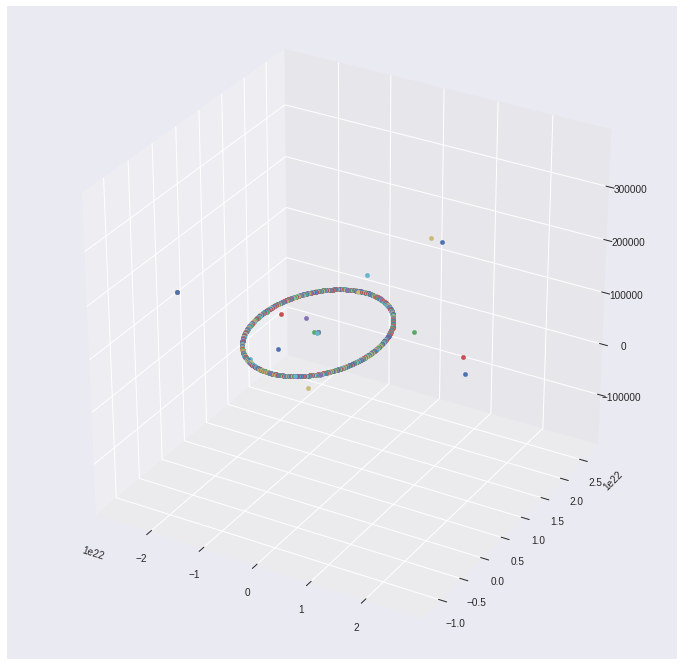

In [278]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

from tqdm import trange
simulation_steps = 1000
time_step = np.float32(10000)  # s
simulation_history = []

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

for space_object in space_objects[:1]:
    print(space_object)
    time0 = space_object['time']
    x0, y0, z0, vx0, vy0, vz0 = [space_object[var] \
                                 for var in ('x', 'y', 'z', 'vx', 'vy', 'vz')]
    # vx0, vy0, vz0 = 0,0,0
    objects_steps = []
    for simulation_step in trange(simulation_steps):
        rk4(drv.In(x0), drv.In(y0), drv.In(z0), 
            drv.In(vx0), drv.In(vy0), drv.In(vz0), 
            drv.Out(x1), drv.Out(y1), drv.Out(z1),
            drv.Out(vx1), drv.Out(vy1), drv.Out(vz1), drv.In(time_step), 
            block = block_dim, grid = grid_dim)

        object_step = dict()
        
        object_step['x'] = x1
        object_step['y'] = y1
        object_step['z'] = z1
        object_step['vx'] = vx1
        object_step['vy'] = vy1
        object_step['vz'] = vz1
        objects_steps.append(object_step)
        
        x0, y0, z0, vx0, vy0, vz0 =  x1, y1, z1, vx1, vy1, vz1
        ax.scatter3D( x1, y1, z1)

    simulation_history.append(objects_steps)

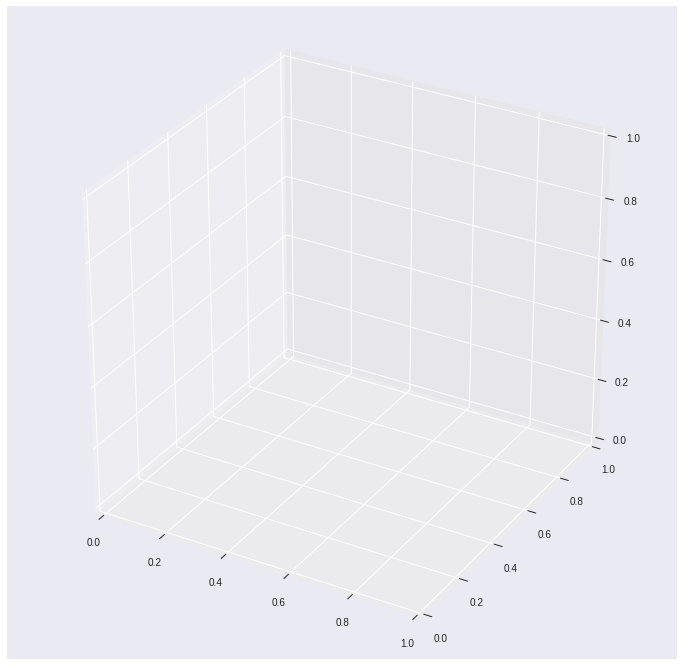

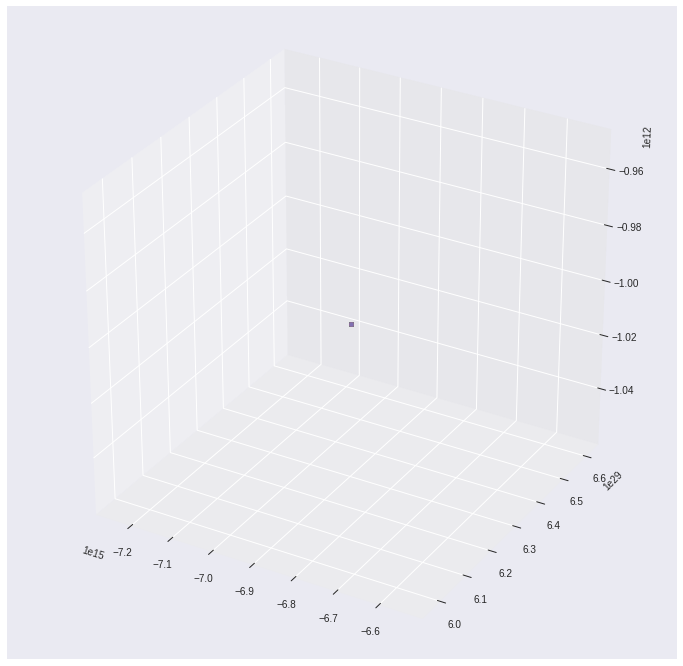

In [242]:


# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 


plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

for object_step in objects_steps:
    ax.scatter3D(object_step['x'], object_step['y'], object_step['z'])
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

{'time': 0.0, 'object_id': 0, 'x': 25217.424362950926, 'y': -496457.41386781185, 'z': 650671.2495281389, 'vx': 0.0014348032818816137, 'vy': -0.00088002800475806, 'vz': -0.0007270622299984097, 'size': 5.933089989621293}


ValueError: ignored

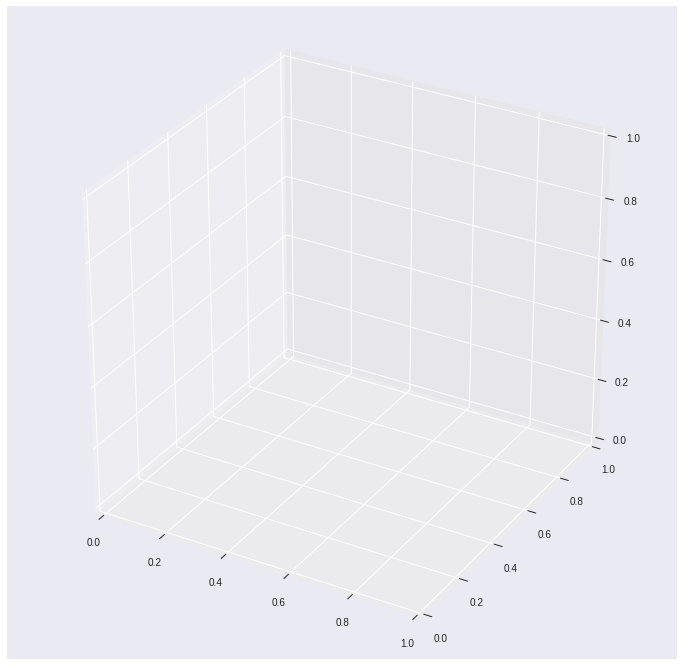

In [123]:
from tqdm import trange
simulation_steps = 10000
time_step = 0.001  # s
simulation_history = []

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

for space_object in space_objects[:1]:
    print(space_object)
    time0 = space_object['time']
    x0, y0, z0, vx0, vy0, vz0 = [space_object[var] \
                                 for var in ('x', 'y', 'z', 'vx', 'vy', 'vz')]
    # vx0, vy0, vz0 = 0,0,0
    objects_steps = []
    for simulation_step in trange(simulation_steps):
        Ek4_step_cuda(time0+simulation_step*time_step, 
                                 x0, y0, z0, vx0, vy0, vz0,
                                                timestep=time_step,
                                                x1, y1, z1, vx1, vy1, vz1)
       
       
        object_step = dict()
        
        object_step['x'] = x1
        object_step['y'] = y1
        object_step['z'] = z1
        object_step['vx'] = vx1
        object_step['vy'] = vy1
        object_step['vz'] = vz1
        objects_steps.append(object_step)
        
        x0, y0, z0, vx0, vy0, vz0 =  x1, y1, z1, vx1, vy1, vz1
        ax.scatter3D( x1, y1, z1)

    simulation_history.append(objects_steps)